In [11]:
!pip install datasets

In [75]:
from datasets import load_dataset
dataset = load_dataset("mshenoda/spam-messages")

In [77]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 47392
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 5923
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 5926
    })
})

In [79]:
from datasets import concatenate_datasets

In [81]:
merged_dataset = concatenate_datasets([
    dataset['train'],
    dataset['validation'],
    dataset['test']
])

In [83]:
merged_dataset

Dataset({
    features: ['label', 'text'],
    num_rows: 59241
})

In [85]:
df = merged_dataset.to_pandas()

In [87]:
df.head()

,label,text
0,ham,"Funny fact Nobody teaches volcanoes 2 erupt, t..."
1,ham,I sent my scores to sophas and i had to do sec...
2,spam,We know someone who you know that fancies you....
3,ham,Only if you promise your getting out as SOON a...
4,spam,Congratulations ur awarded either �500 of CD g...


In [37]:
df.shape

(59241, 2)

In [124]:
import pandas as pd
import re
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder


In [126]:
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [128]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})


In [130]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()                              # lowercase
    text = re.sub(r'[^a-zA-Z]', ' ', text)           # remove numbers & punctuation
    text = re.sub(r'\s+', ' ', text).strip()         # remove extra spaces
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)


In [132]:
df['clean_text'] = df['text'].apply(clean_text)

In [134]:
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [136]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [138]:
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)


(47334, 5000)
(11834, 5000)


In [140]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [142]:
lr_baseline = LogisticRegression(max_iter=1000)
lr_baseline.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [144]:
y_pred_baseline = lr_baseline.predict(X_test_tfidf)


In [146]:
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print("Baseline Accuracy:", baseline_accuracy)


Baseline Accuracy: 0.9368767956734831


In [148]:
print("Baseline Classification Report:\n")
print(classification_report(y_test, y_pred_baseline))

Baseline Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7118
           1       0.93      0.91      0.92      4716

    accuracy                           0.94     11834
   macro avg       0.94      0.93      0.93     11834
weighted avg       0.94      0.94      0.94     11834



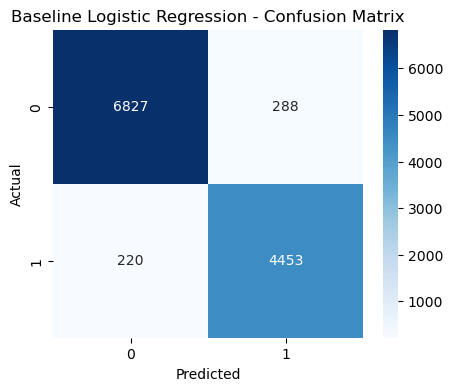

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

cm_baseline = confusion_matrix(y_test, y_pred_baseline)

plt.figure(figsize=(5,4))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues')
plt.title("Baseline Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [150]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs']
}

grid = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid.fit(X_train_tfidf, y_train)

,estimator,LogisticRegre...max_iter=1000)
,param_grid,"{'C': [0.01, 0.1, ...], 'penalty': ['l2'], 'solver': ['liblinear', 'lbfgs']}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [151]:
print("Best Parameters:", grid.best_params_)

Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [154]:
lr_tuned = grid.best_estimator_
y_pred_tuned = lr_tuned.predict(X_test_tfidf)

In [156]:
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
print("Tuned Accuracy:", tuned_accuracy)

Tuned Accuracy: 0.9433834713537266


In [192]:
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
print(cm_tuned)

[[6829  289]
 [ 381 4335]]


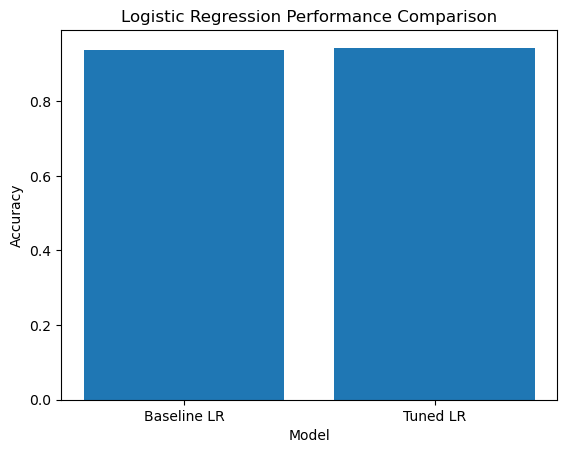

In [158]:
import matplotlib.pyplot as plt

models = ['Baseline LR', 'Tuned LR']
accuracies = [baseline_accuracy, tuned_accuracy]

plt.figure()
plt.bar(models, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Performance Comparison')
plt.show()

<Figure size 640x480 with 0 Axes>

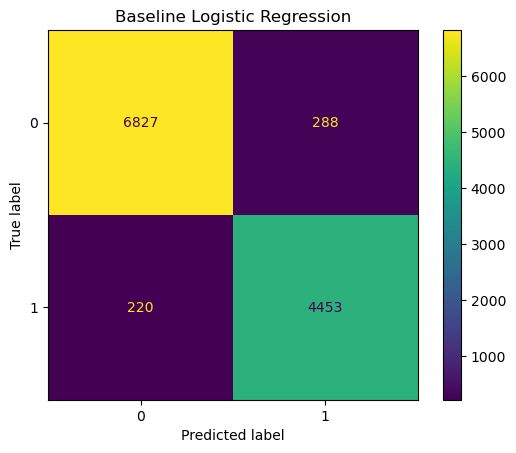

<Figure size 640x480 with 0 Axes>

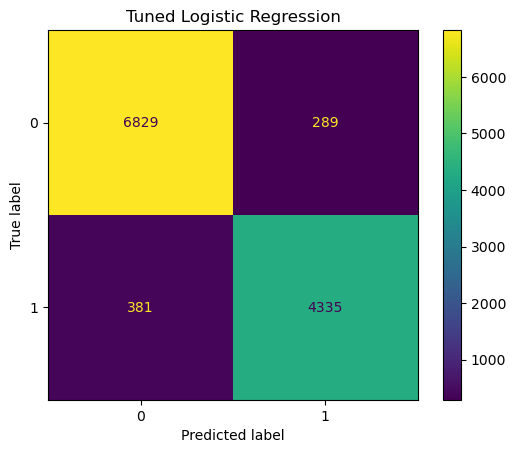

In [194]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure()
ConfusionMatrixDisplay(cm_baseline).plot()
plt.title("Baseline Logistic Regression")
plt.show()

plt.figure()
ConfusionMatrixDisplay(cm_tuned).plot()
plt.title("Tuned Logistic Regression")
plt.show()

In [162]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [164]:
nb_baseline = MultinomialNB()
nb_baseline.fit(X_train_tfidf, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [166]:
y_pred_nb_baseline = nb_baseline.predict(X_test_tfidf)

In [168]:
nb_baseline_accuracy = accuracy_score(y_test, y_pred_nb_baseline)
print("Baseline Naive Bayes Accuracy:", nb_baseline_accuracy)

Baseline Naive Bayes Accuracy: 0.9170187595065067


In [170]:
print("Baseline Naive Bayes Classification Report:\n")
print(classification_report(y_test, y_pred_nb_baseline))

Baseline Naive Bayes Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7118
           1       0.88      0.91      0.90      4716

    accuracy                           0.92     11834
   macro avg       0.91      0.92      0.91     11834
weighted avg       0.92      0.92      0.92     11834



In [172]:
cm_nb_baseline = confusion_matrix(y_test, y_pred_nb_baseline)
print(cm_nb_baseline)

[[6544  574]
 [ 408 4308]]


In [174]:
from sklearn.model_selection import GridSearchCV

param_grid_nb = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0]
}

grid_nb = GridSearchCV(
    MultinomialNB(),
    param_grid_nb,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_nb.fit(X_train_tfidf, y_train)

,estimator,MultinomialNB()
,param_grid,"{'alpha': [0.01, 0.1, ...]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,0.01


In [176]:
print("Best Alpha:", grid_nb.best_params_)

Best Alpha: {'alpha': 0.01}


In [178]:
nb_tuned = grid_nb.best_estimator_
y_pred_nb_tuned = nb_tuned.predict(X_test_tfidf)

In [180]:
nb_tuned_accuracy = accuracy_score(y_test, y_pred_nb_tuned)
print("Tuned Naive Bayes Accuracy:", nb_tuned_accuracy)

Tuned Naive Bayes Accuracy: 0.9170187595065067


In [182]:
print("Tuned Naive Bayes Classification Report:\n")
print(classification_report(y_test, y_pred_nb_tuned))

Tuned Naive Bayes Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7118
           1       0.88      0.91      0.90      4716

    accuracy                           0.92     11834
   macro avg       0.91      0.92      0.91     11834
weighted avg       0.92      0.92      0.92     11834



In [188]:
cm_nb_tuned = confusion_matrix(y_test, y_pred_nb_tuned)
print(cm_nb_tuned)

[[6540  578]
 [ 404 4312]]


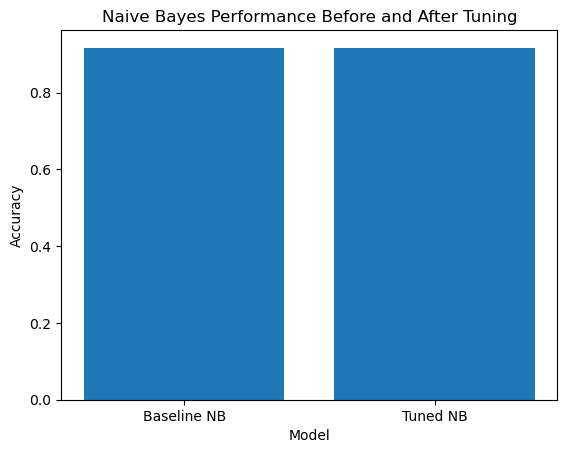

In [184]:
import matplotlib.pyplot as plt

models_nb = ['Baseline NB', 'Tuned NB']
accuracies_nb = [nb_baseline_accuracy, nb_tuned_accuracy]

plt.figure()
plt.bar(models_nb, accuracies_nb)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Naive Bayes Performance Before and After Tuning')
plt.show()

<Figure size 640x480 with 0 Axes>

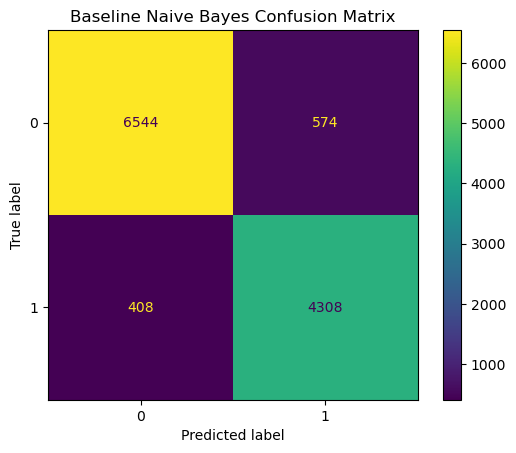

<Figure size 640x480 with 0 Axes>

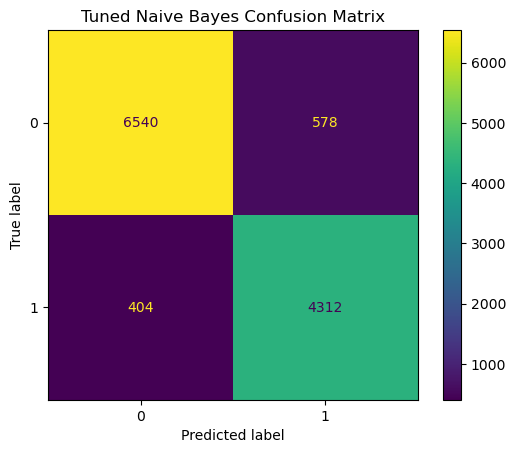

In [190]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure()
ConfusionMatrixDisplay(cm_nb_baseline).plot()
plt.title("Baseline Naive Bayes Confusion Matrix")
plt.show()

plt.figure()
ConfusionMatrixDisplay(cm_nb_tuned).plot()
plt.title("Tuned Naive Bayes Confusion Matrix")
plt.show()

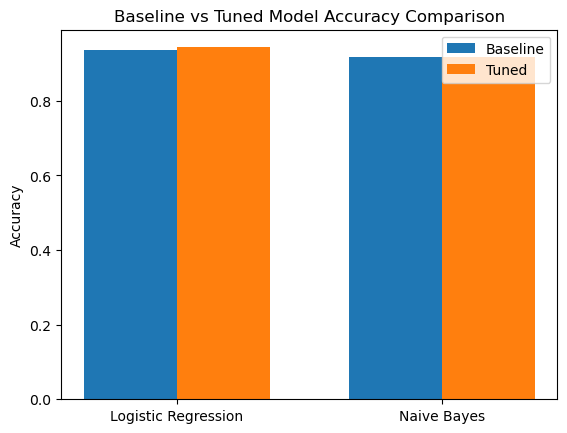

In [196]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Logistic Regression', 'Naive Bayes']
baseline_scores = [baseline_accuracy, nb_baseline_accuracy]
tuned_scores = [tuned_accuracy, nb_tuned_accuracy]

x = np.arange(len(models))
width = 0.35

plt.figure()
plt.bar(x - width/2, baseline_scores, width, label='Baseline')
plt.bar(x + width/2, tuned_scores, width, label='Tuned')

plt.xticks(x, models)
plt.ylabel('Accuracy')
plt.title('Baseline vs Tuned Model Accuracy Comparison')
plt.legend()
plt.show()

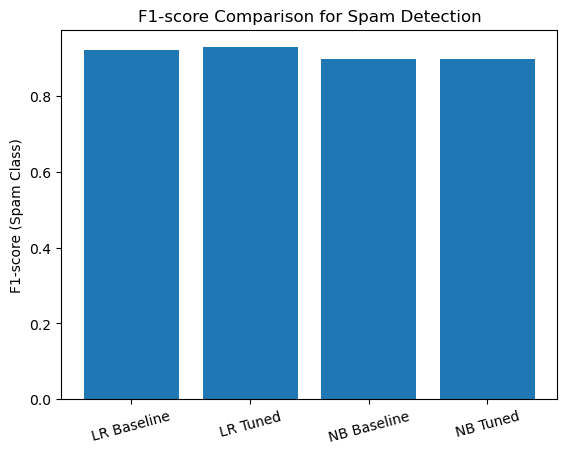

In [198]:
from sklearn.metrics import classification_report

# Extract F1-score for spam class (label = 1)
lr_baseline_f1 = classification_report(y_test, y_pred_baseline, output_dict=True)['1']['f1-score']
lr_tuned_f1 = classification_report(y_test, y_pred_tuned, output_dict=True)['1']['f1-score']

nb_baseline_f1 = classification_report(y_test, y_pred_nb_baseline, output_dict=True)['1']['f1-score']
nb_tuned_f1 = classification_report(y_test, y_pred_nb_tuned, output_dict=True)['1']['f1-score']

models = ['LR Baseline', 'LR Tuned', 'NB Baseline', 'NB Tuned']
f1_scores = [lr_baseline_f1, lr_tuned_f1, nb_baseline_f1, nb_tuned_f1]

plt.figure()
plt.bar(models, f1_scores)
plt.ylabel('F1-score (Spam Class)')
plt.title('F1-score Comparison for Spam Detection')
plt.xticks(rotation=15)
plt.show()

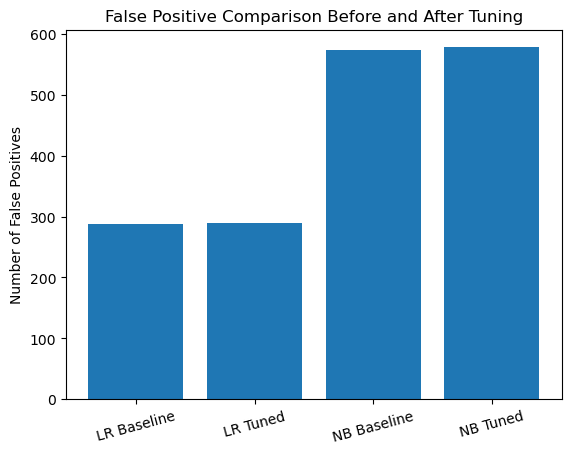

In [200]:
# False positives = ham predicted as spam
fp_lr_baseline = cm_baseline[0][1]
fp_lr_tuned = cm_tuned[0][1]

fp_nb_baseline = cm_nb_baseline[0][1]
fp_nb_tuned = cm_nb_tuned[0][1]

models = ['LR Baseline', 'LR Tuned', 'NB Baseline', 'NB Tuned']
false_positives = [
    fp_lr_baseline,
    fp_lr_tuned,
    fp_nb_baseline,
    fp_nb_tuned
]

plt.figure()
plt.bar(models, false_positives)
plt.ylabel('Number of False Positives')
plt.title('False Positive Comparison Before and After Tuning')
plt.xticks(rotation=15)
plt.show()